This test function is used to test the correctness of the overall program on calculating gradients

In [1]:
import numpy as np
from scipy import interpolate
import os
import sys


sys.path.append('..\\src')
from Utilities.wavelength import Wavelength
from Geometries.polygon import FunctionDefinedPolygon
from Figures_of_merit.modematch import ModeMatch
from Optimizers.generic_optimizers import ScipyOptimizers
from optimization import Optimization

%load_ext autoreload
%autoreload 2

In [2]:
## Define base script ##
base_script = os.path.join(os.getcwd(), 'Y_splitter.lsf')
## Define spectral range ##
wavelengths = Wavelength(start = 1300e-9, stop = 1800e-9, points = 21)
## Define optimizable geometry ##
# We will use calss FunctionDefinedPolygon here, and the parameterized Polygon will receive 11 points of polygon's upper part (aligned in clockwise) and return 200 cubic interpolated points (aligned in counter-clockwise), making it quite smooth
num = 11

initial_points_x = np.linspace(- 1.0e-6, 1.0e-6, num)
initial_points_y = np.linspace(0.25e-6, 0.6e-6, num)
def taper_splitter(params = initial_points_y):
    """Parameters are the y coordinate of the nodes consisting the upper part of the polygon"""
    points_x = np.concatenate(([initial_points_x.min() - 0.01e-6], initial_points_x, [initial_points_x.max() + 0.01e-6]))
    points_y = np.concatenate(([initial_points_y.min()],  params, [initial_points_y.max()]))
    n_interpolation_points = 100
    polygon_points_x = np.linspace(points_x.min(), points_x.max(), n_interpolation_points)
    interpolator = interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[: : -1] + polygon_points_down)
    return polygon_points

bounds = np.array([(0.2e-6, 0.8e-6)] * num)
geometry = FunctionDefinedPolygon(func = taper_splitter, start_params = initial_points_y, bounds = bounds, dx = 1e-9, z = 0.0, depth = 220e-9, eps_in = 2.8 ** 2, eps_out = 1.44 ** 2, edge_precision = 5)

## Define figure of merit ##
fom = ModeMatch(monitor_name = 'fom', mode_num = 2, direction = 'Forward', mul_freq_src = True, target_T_foward = lambda wl: np.ones(wl.size), norm_p = 1)

## Define the optimization algorithm ##
# This will run Scipy's implementation pf the L-BFGS-B algorithm for at most 30 iteration. Since the variable are on the order of 1e-6, they are scale up to be on the order of 1.
optimizer = ScipyOptimizers(max_iter = 30, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

## Put everything together
# We will test the dir_grad == True and dir_grad == False two cases with the direct differentiation method
opt1 = Optimization(base_script = base_script, wavelength = wavelengths, fom = fom, geometry = geometry, optimizer = optimizer, hide_fdtd_cad = False, dir_grad = True)
opt2 = Optimization(base_script = base_script, wavelength = wavelengths, fom = fom, geometry = geometry, optimizer = optimizer, hide_fdtd_cad = False, dir_grad = False)

Use the gradient calculated from FDTD directly


First we want to check that the dir_grad == True case is correct where we will use d_epses in lumerical FDTD, and we use the differentiation to calculate the gradients directly to compare with the one calculated using gradient_fields

d:\program\adjoint_method\Lumopt\Test_grad\..\src\Utilities\plotter.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Running forward simulation
FOM = 0.7252426110995587
Running adjoint simulation
Calculating gradients
get d eps under dx =1e-09
...........


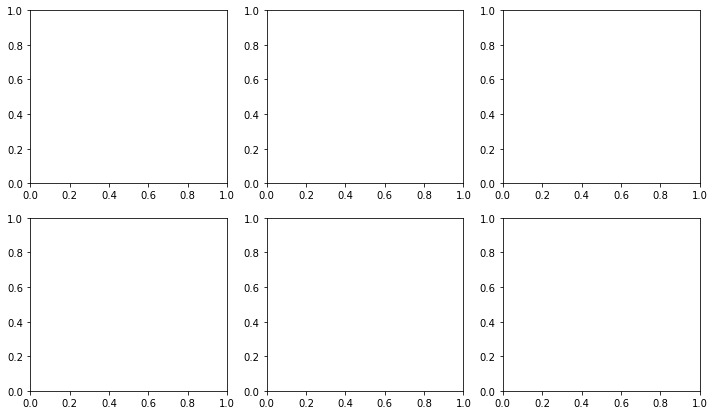

In [3]:
opt1.initialize()
opt1.init_plotter()
fom_To = opt1.callable_fom(initial_points_y) # T stands for true and o stands for original
grad_T = opt1.callable_jac(initial_points_y)

following part is trying to calculate the gradient under dir_grad == True case with direct differentiation method

In [4]:
grad_1_d = []
for index in range(11):
    d_params = initial_points_y.copy()
    d_params[index] = d_params[index] + opt1.geometry.dx # perturb the first parameter
    fom_T1 = opt1.callable_fom(d_params)
    grad_1_d.append((fom_T1 - fom_To) / opt1.geometry.dx) # 1 stands for the first parameter and d stands for direct differentiation
grad_1_d = np.array(grad_1_d)

Running forward simulation
FOM = 0.7254040912530839
Running forward simulation
FOM = 0.7254807119773552
Running forward simulation
FOM = 0.7252457513395432
Running forward simulation
FOM = 0.7245560238133248
Running forward simulation
FOM = 0.7244296147349318
Running forward simulation
FOM = 0.725215562272393
Running forward simulation
FOM = 0.7259304091509488
Running forward simulation
FOM = 0.7260498232372739
Running forward simulation
FOM = 0.7258842303040883
Running forward simulation
FOM = 0.7254607429910922
Running forward simulation
FOM = 0.7249310289479022


Running forward simulation
FOM = 0.7256227304692469
Running adjoint simulation
Calculating gradients
Calculateing gradients for 200 edges
........................................................................................................................................................................................................


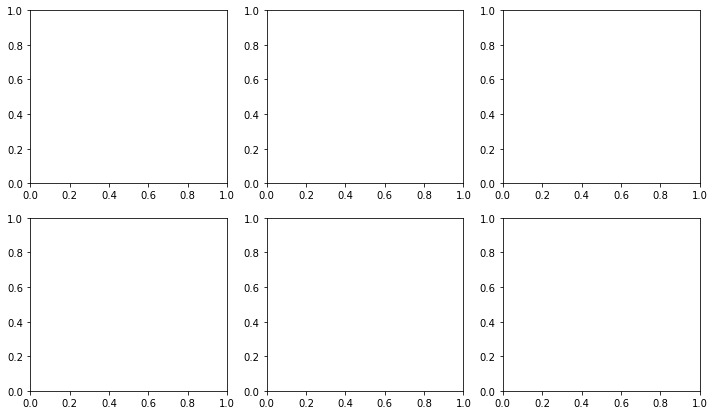

In [5]:
opt2.initialize()
opt2.init_plotter()
fom_Fo = opt2.callable_fom(initial_points_y) # T stands for true and o stands for original
grad_F = opt2.callable_jac(initial_points_y)

In [5]:
# opt1.sim.fdtd.close()
opt2.sim.fdtd.close()

This part is used to compare the forward field, adjoint field and the gradient field for the dir_grad == True case

This is used to check the correctness of simulated field by comparing with the standard one

Text(0.5, 1.0, 'forward field $E_y$ relative error')

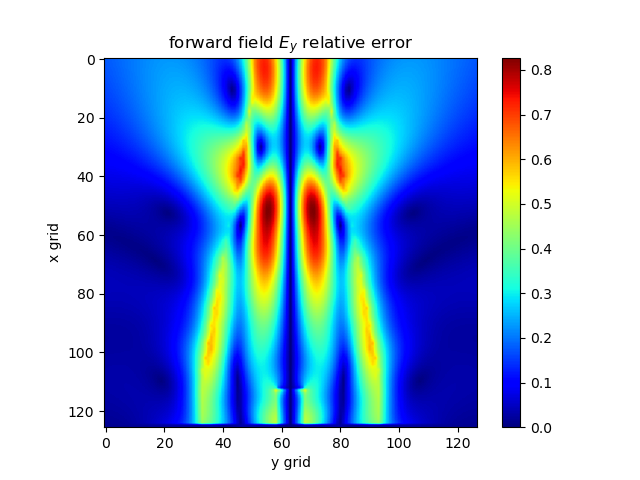

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib widget

### Check forward fields and adjoint fields ###
with open('adjoint_fields_my.pkl', 'rb') as f:
    forward_fields = pickle.loads(f.read())
E_forward = forward_fields['E']['E']

index = 0
Ef_x = np.abs(E_forward[:, :, 0, index, 0])
Ef_y = np.abs(E_forward[:, :, 0, index, 1])
Ef_z = np.abs(E_forward[:, :, 0, index, 2])
norm_Ef = np.sqrt(Ef_x * Ef_x + Ef_y * Ef_y + Ef_z * Ef_z)
# plt.imshow(np.real(norm_E), cmap = 'jet')

with open('adjoint_fields_m.pkl', 'rb') as f:
    adjoint_fields = pickle.loads(f.read())
E_adjoint = adjoint_fields['E']['E']

index = 0
Ea_x = np.abs(E_adjoint[:, :, 0, index, 0])
Ea_y = np.abs(E_adjoint[:, :, 0, index, 1])
Ea_z = np.abs(E_adjoint[:, :, 0, index, 2])
norm_Ea = np.sqrt(Ea_x * Ea_x + Ea_y * Ea_y + Ea_z * Ea_z)
# plt.imshow(np.real(norm_E), cmap = 'jet')
plt.imshow((Ef_y - Ea_y) / Ef_y, cmap = 'jet')
plt.colorbar()
plt.clim([-1, 1])
plt.xlabel('y grid')
plt.ylabel('x grid')
plt.title('forward field $E_y$ relative error')



### Check Gradient Fields ###

# with open('gradient_fields_m.pkl', 'rb') as f:
#     gradient_fields = pickle.loads(f.read())

# gradient_fields = np.sum(gradient_fields[:, :, :, 0, :], axis = 3).squeeze()
# # plt.imshow(np.real(gradient_fields), cmap = 'jet')

# with open('gradient_fields_my.pkl', 'rb') as f:
#     gradient_fields_2 = pickle.loads(f.read())

# gradient_fields_2 = np.sum(gradient_fields_2[:, :, :, 0, :], axis = 3).squeeze()
# plt.imshow((np.real(gradient_fields_2) - np.real(gradient_fields)) / np.real(gradient_fields), cmap = 'jet')
# plt.colorbar()
# plt.clim([-1, 1])
# plt.xlabel('y grid')
# plt.ylabel('x grid')
# plt.title('gradient field relative error')

This part is used to load the standard and modified standard program's data

In [10]:
### To test the dir_grad == True case ###
## Data from lumopt_standard ##
fom_standard = 0.7263055123506592
grad_T_standard = np.array([291577.46287891, 238718.22068554 ,-15064.19831036, -682393.07822047, -788704.78039221, -65156.45465704, 637232.10699336, 760436.58657923, 590858.54599047, 197150.60935913, -375175.94003869])
grad_1_d_standard = np.array([190530.33555593845, 255814.47437583725, 18539.066545475434, -653341.7492463611, -773626.4122902846, -52692.536222087576, 643302.9504011589, 754611.5416725562, 583290.1738558327, 186288.13358101403, -407832.3843759168])
# the following are the one with multifrequency points are set
grad_T_standard_2 = np.array([247732.85795242, 237184.0158454, -9500.30390982, -688039.58625779, -797104.6299523, -68490.76796386, 642566.21554934, 776537.6696526, 615026.90456015, 215699.87985561, -355136.0617032])
grad_1_d_standard_2 = np.array([133689.6268683274, 246696.40964625205, 17149.76613942376, -666258.1754689477, -788485.6665204553, -62339.9102727129, 642607.9716356226, 764626.6209428987, 601786.3182156135, 199224.3315819264, -395099.48810934054])

This part is used to compare the result of adjoint method and the direct differentiation method under the dir_grad == Trus case

Text(0.5, 1.0, 'test_grad dx = 1e-9')

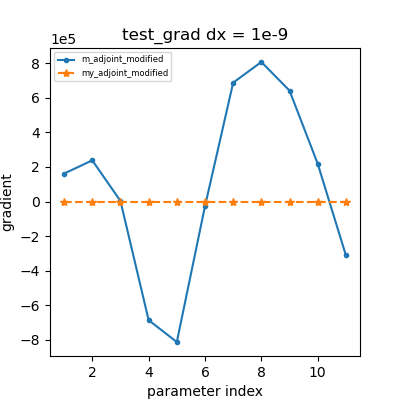

In [8]:
import matplotlib.pyplot as plt
%matplotlib widget
### Draw the gradient_T and gradient_1_d fields ###
fig = plt.figure(num = 1,figsize = (4, 4))
ax = fig.add_subplot(111)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
ax.plot(np.linspace(1, 11, 11), grad_1_d, '.-', label = 'm_adjoint_modified')
ax.plot(np.linspace(1, 11, 11), grad_T, '*--', label = 'my_adjoint_modified')
ax.legend(fontsize = 6)

ax.set_xlabel('parameter index')
ax.set_ylabel('gradient')
ax.set_title('test_grad dx = 1e-9')

### Draw the error field to compare ###
# fig = plt.figure(num = 1, figsize = (4, 4))
# ax = fig.add_subplot(111)
# plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
# ax.plot(np.linspace(1, 11, 11), np.abs(grad_T - grad_1_d) / grad_1_d, '.-', label = 'my program')
# ax.plot(np.linspace(1, 11, 11), np.abs(grad_T_standard - grad_1_d_standard) / grad_1_d_standard, '*--', label = 'standard program')
# ax.plot(np.linspace(1, 11, 11), np.abs(grad_T_standard_2 - grad_1_d_standard_2) / grad_1_d_standard_2, 'o:', label = 'modified standard program')
# ax.legend(fontsize = 6)

# ax.set_xlabel('parameter index')
# ax.set_ylabel('relative error')
# ax.set_title('test_grad')

The following parts are used to test the gradients for the test_grad == False case, first get the fom and gradients from the modified standard program

In [12]:
### To test the dir_grad == False case ###
## Data from lumopt_standard, mult_freq are set well ##
fom_F_standard = 0.7256240148137447
grad_F_standard = [-378788.86260005, 102508.3948194, 68665.41810821, -450204.83594622, -621241.64069946, -86488.39065845, 482181.06966714, 606340.31341035, 489924.35122481, 196489.69682569, -331331.29156058]

This part is used to compare the forward fields and adjoint fields (E, D) from modified standard program and mine, which is the basis to calcualte the gradient (and thus is used to check the gradient)

Text(0.5, 1.0, 'forward field $E_y$ relative error')

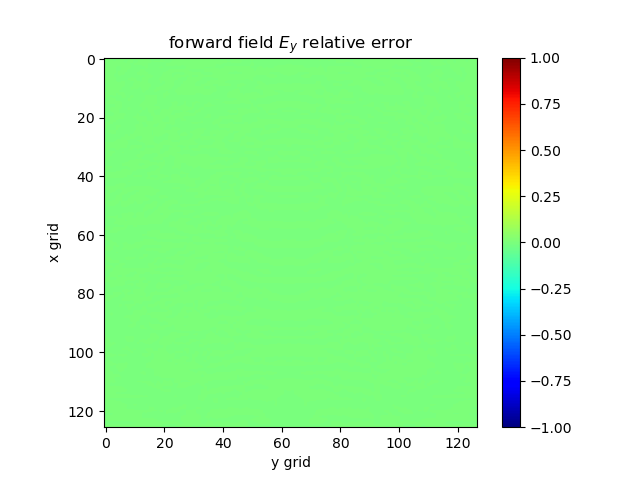

In [13]:

import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib widget

# with open('test_2_field/D_adjoint_my.pkl', 'rb') as f:
#     my_fields = pickle.loads(f.read())

my_fields = np.load('..//test_2_field//D_forward_my.npy')


index = 0
my_x = np.abs(my_fields[:, :, 0, index, 0])
my_y = np.abs(my_fields[:, :, 0, index, 1])
my_z = np.abs(my_fields[:, :, 0, index, 2])
my_norm = np.sqrt(my_x * my_x + my_y * my_y + my_z * my_z)
# plt.imshow(np.real(norm_my), cmap = 'jet')

# with open('test_2_field/D_adjoint_m.pkl', 'rb') as f:
#     modified_fields = pickle.loads(f.read())

modified_fields = np.load('..//test_2_field//D_forward_m.npy')

index = 0
modified_x = np.abs(modified_fields[:, :, 0, index, 0])
modified_y = np.abs(modified_fields[:, :, 0, index, 1])
modified_z = np.abs(modified_fields[:, :, 0, index, 2])
modified_norm = np.sqrt(modified_x * modified_x + modified_y * modified_y + modified_z * modified_z)
# plt.imshow(np.real(norm_modified), cmap = 'jet')

plt.imshow((my_norm - modified_norm) / modified_norm, cmap = 'jet')
plt.colorbar()
plt.clim([-1, 1])
plt.xlabel('y grid')
plt.ylabel('x grid')
plt.title('forward field $E_y$ relative error')

In [3]:
import numpy as np
grad_pair_edges_my = np.load('./test_2_field/first_edge_integrand_my.npy')
grad_pair_edges_m = np.load('./test_2_field/first_edge_integrand_m.npy')


In [4]:
grad_F = [84238.7445168, 237401.68985547, -11193.67702164, -678255.32238834, -774732.13047177, -63765.26567913, 615439.50917324, 754171.52169819, 585570.55427306, 210919.41680676, -347783.51512091]

Test the whole optimization

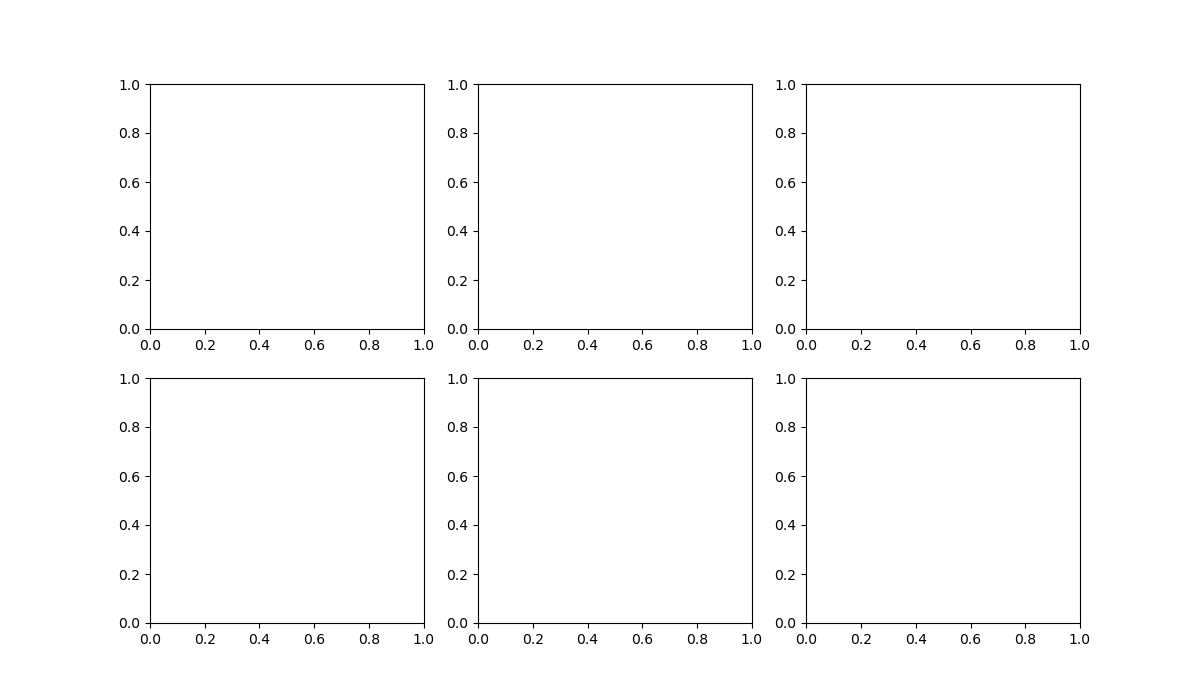

Run the scipy optimization 

Bounds = [[0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]] 

Start = [0.25  0.285 0.32  0.355 0.39  0.425 0.46  0.495 0.53  0.565 0.6  ] 

Running forward simulation
FOM = 0.7252426110995587
Running adjoint simulation
Calculating gradients
get d eps under dx =1e-09
...........
Running forward simulation
FOM = 0.5613549349952724
Running adjoint simulation
Calculating gradients
get d eps under dx =1e-09
...........
Running forward simulation
FOM = 0.8110156657406358
Running adjoint simulation
Calculating gradients
get d eps under dx =1e-09
...........
Plots updated with iteration 0 result
Running forward simulation
FOM = 0.8516924025364874
Running adjoint simulation
Calculating gradients
get d eps under dx =1e-09
...........
Plots updated with iteration 1 result
Running forward simulation
FOM = 0.9023526974288252
Running adjoint simulation
Calculating gradients
get d eps under dx =1e-09
.

(0.980430661814671,
 array([2.49824710e-07, 2.67262849e-07, 4.07101568e-07, 5.01209936e-07,
        6.84756642e-07, 6.80140529e-07, 7.05466694e-07, 6.82921257e-07,
        6.77787192e-07, 6.59233365e-07, 6.20299277e-07]))

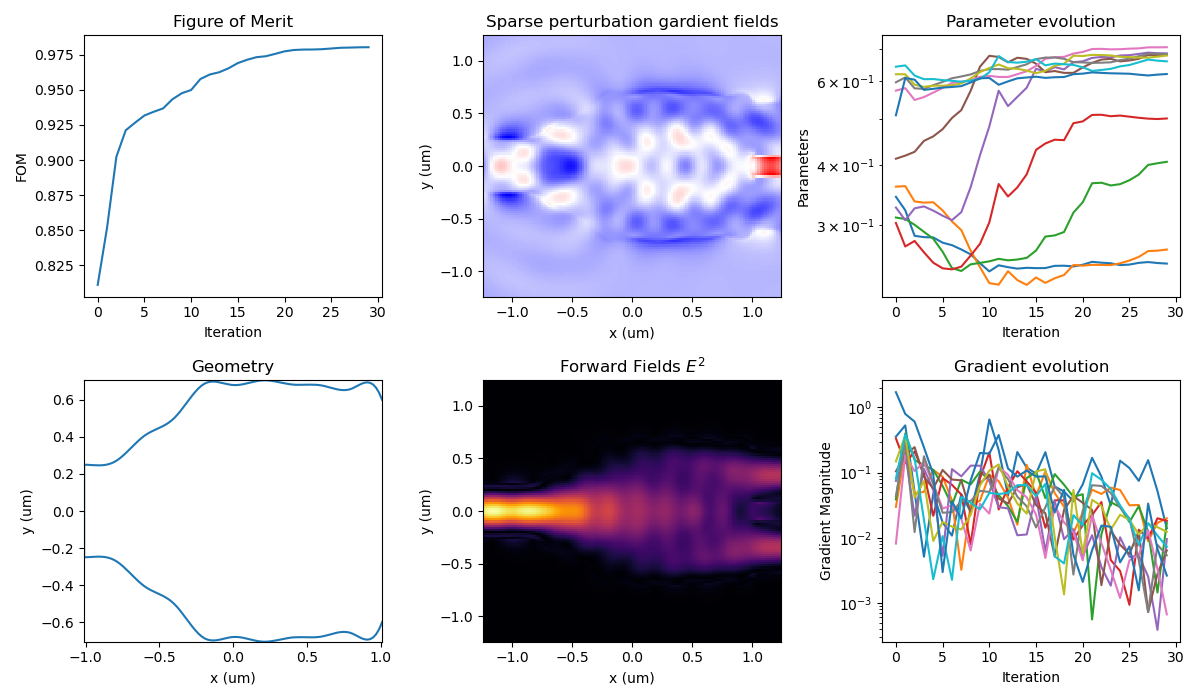

In [3]:
%matplotlib widget
opt1.run()

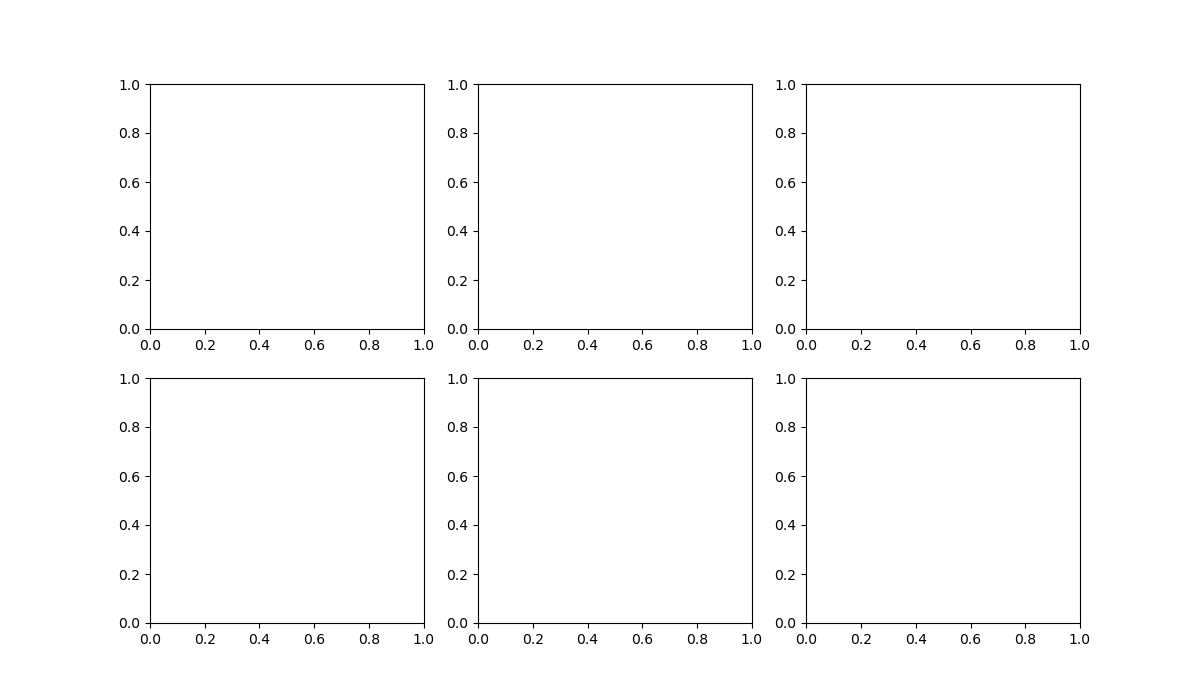

Run the scipy optimization 

Bounds = [[0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]] 

Start = [0.25  0.285 0.32  0.355 0.39  0.425 0.46  0.495 0.53  0.565 0.6  ] 

Running forward simulation
FOM = 0.7256227304692469
Running adjoint simulation
Calculating gradients
Calculateing gradients for 200 edges
........................................................................................................................................................................................................
Running forward simulation
FOM = 0.5344128684636639
Running adjoint simulation
Calculating gradients
Calculateing gradients for 200 edges
........................................................................................................................................................................................................
Running forward simulation
FOM = 0.8130316974635217
Running adjoint simulation
Cal

(0.983350908329247,
 array([2.54976905e-07, 4.19239821e-07, 4.64479444e-07, 7.59567152e-07,
        7.01086140e-07, 7.39003644e-07, 7.22269491e-07, 7.10922100e-07,
        7.03100083e-07, 6.63974836e-07, 6.25533958e-07]))

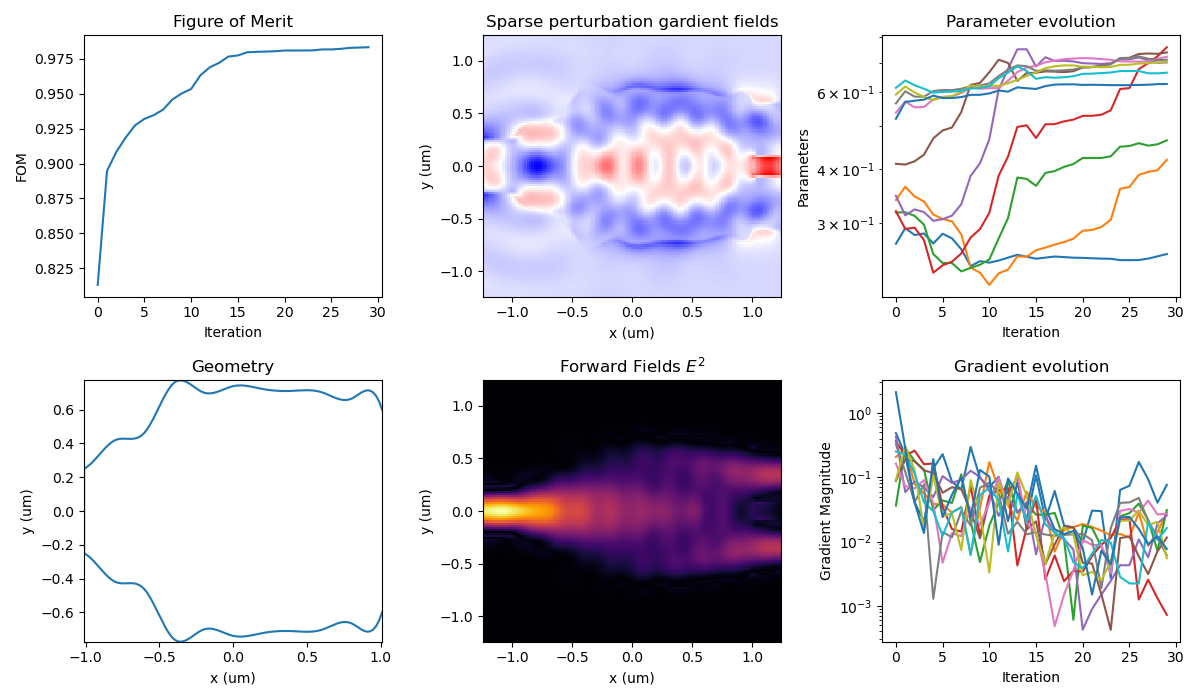

In [3]:
%matplotlib widget
opt2.run()

In [17]:
%matplotlib widget
opt2.plotter.fig.savefig('opt_30_False.jpg')